In [368]:
#| include: false

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
from sklearn.metrics import confusion_matrix

In [350]:
#| include: false

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train["Species"] = train["Species"].str.split().str.get(0)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


# Explore

## Summary Statistics

The first task for this project is to explore the data. This will be done by creating a table of summary statistics for the data set. In order to do this we want to not only look at the quantitative data, but also the relevant qualitative data. In order to do this, for the binary data (sex and clutch completion) we can simply convert the type to an integer. For the island, it is a bit more complicated since there are 3 islands, so we will need to count the number of each island. We then simply group by the species and are able to get the averages for each variable for each species.

In [351]:
df_stats = train.copy()
df_stats["Female"] = (df_stats["Sex"] == "FEMALE").astype(int)
df_stats["Clutch Completion"] = (df_stats["Clutch Completion"] == "Yes").astype(int)
summary_table = df_stats.groupby("Species").mean(numeric_only=True).drop(columns=["Sample Number"])
island_percentages = df_stats.groupby("Species")["Island"].value_counts(normalize=True).unstack(fill_value=0)
final_summary = summary_table.join(island_percentages)
final_summary.reset_index(inplace=True)

display(final_summary)

,Species,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Female,Biscoe,Dream,Torgersen
0,Adelie,0.900000,38.970588,18.409244,190.084034,3718.487395,8.861824,-25.796897,0.441667,0.275,0.375,0.35
1,Chinstrap,0.824561,48.826316,18.366667,196.000000,3743.421053,9.331004,-24.553401,0.543860,0.000,1.000,0.00
2,Gentoo,0.918367,47.073196,14.914433,216.752577,5039.948454,8.247341,-26.149389,0.500000,1.000,0.000,0.00


Looking at the summary statistics we immediately get a clue as to which variables may or may not be useful in predicting the species. For example, Chinstrap and Gentoo penguins, only exist on one island each which, indicating that training based on the island will be very valuable. Additionally, Gentoo penguins are significantly larger with longer flippers on average while Adelie's have much shorter Culmens than the others. The sex measurements, on the other hand, do not appear to be very useful as their distributions are more similar across the species.

## Visualizations

To get a better sense of some of the quantitative variables, we can visualize pairs of them in scatter plots. This will go further than simply using the means to see if there are any clear patterns between species in the data. We will look at the Culmen sizes, flipper lengths, body masses, and blood measurements.

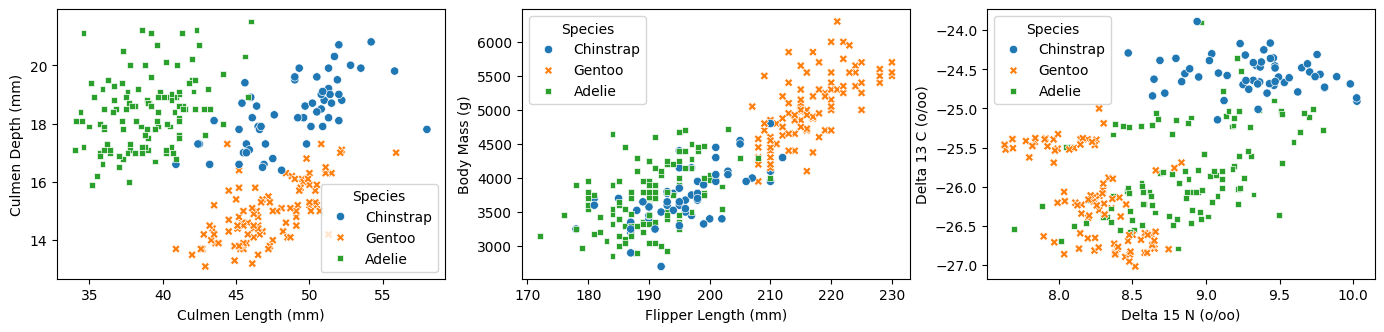

In [352]:
fig, ax = plt.subplots(1, 3, figsize = (17, 3.5))

p1 = sns.scatterplot(train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", hue = "Species", style = "Species", ax = ax[0])
p1 = sns.scatterplot(train, x = "Flipper Length (mm)", y = "Body Mass (g)", hue = "Species", style = "Species", ax = ax[1])
p2 = sns.scatterplot(train, x = "Delta 15 N (o/oo)", y = "Delta 13 C (o/oo)",  hue = "Species", style = "Species", ax = ax[2])

Looking at these plots, we can see that the species are not perfectly separable on any one variable however there are clear trends. For example, the Culmen sizes form 3 pretty clear clusters, indicating that these variables, when used together, will be useful in predicting the species. The body mass and flipper length plot is also interesting as Gentoo penguins are clearly separated with Chinstrap and Adelie coming in at very similar sizes. The blood measurements are not as useful as the other variables as there is a lot of overlap between the species, but some vague groups still appear.

# Model

## Data Preprocessing

Now that we have more of an idea about each variable, the next step is to train models to determine the most predictive variables. To do this, we first need to preprocess the data to binarize the categorical variables so that they can be used for the models. We will use one-hot encoding for these variables, as shown below.


In [353]:
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  x = df.drop(["Species"], axis = 1)
  x = pd.get_dummies(df)
  return x, y

X_train, y_train = prepare_data(train)

X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Species_Adelie,Species_Chinstrap,Species_Gentoo,Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,False,False,True,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,False,False,True,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,False,True,False,True,False,True,False,True


## Variable and Model Selection

To determine the best variable combinations, we will run some tests on different combinations of 3 variables. To do this we first generate every combination of 2 numeric and 1 categorical variable, which the following lines do so that the combinations can be used later.

In [354]:
all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

combs = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols
    combs.append(cols)

We then loop through the combinations and use cross-validation scoring to determine which combinations perform the best. We not only want to test the variable combinations, we also want to test different models on each combination to see which one is the best. We will test the following models: Logistic Regression, Decision Tree, Random Forest, and Support Vector Machines. We will then use the best model and variables to predict the species of the test data. We test the variable combinations and models simultaneously by performing the cross-validation tests on each model for each combination.

In [355]:
warnings.filterwarnings('ignore')

tests = []

for cols in combs:
    LR = LogisticRegression()
    LR.fit(X_train[cols], y_train)
    LR.score(X_train[cols], y_train)
    cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)
    DTC = DecisionTreeClassifier()
    DTC.fit(X_train[cols], y_train)
    DTC.score(X_train[cols], y_train)
    cv_scores_DTC = cross_val_score(DTC, X_train[cols], y_train, cv = 5)
    RFC = RandomForestClassifier()
    RFC.fit(X_train[cols], y_train)
    RFC.score(X_train[cols], y_train)
    cv_scores_RFC = cross_val_score(RFC, X_train[cols], y_train, cv = 5)
    SVM = SVC()
    SVM.fit(X_train[cols], y_train)
    SVM.score(X_train[cols], y_train)
    cv_scores_SVM = cross_val_score(SVM, X_train[cols], y_train, cv = 5)
    tests.append((cols, cv_scores_LR.mean(), cv_scores_DTC.mean(), cv_scores_RFC.mean(), cv_scores_SVM.mean()))

To display the outcome of these tests we use Pandas to output the average cross-validation score for each model and variable combination. Outputting just the top 5 since the number of combinations is unwieldy, we can observe some interesting things about the combinations and models.

In [356]:
df_results = pd.DataFrame(tests, columns=["Columns", "Logistic Regression", "Decision Tree", "Random Forest", "SVM"])

df_results["Columns"] = df_results["Columns"].apply(lambda x: ", ".join(x))

pd.set_option("display.max_colwidth", None)  # no truncation of column text

df_results = df_results.sort_values(by="Logistic Regression", ascending=False) # sort by cross-val score
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,Columns,Logistic Regression,Decision Tree,Random Forest,SVM
0,"Culmen Length (mm), Culmen Depth (mm), Island_Biscoe, Island_Dream, Island_Torgersen",0.996154,0.976546,0.980468,0.820362
1,"Culmen Length (mm), Culmen Depth (mm), Sex_FEMALE, Sex_MALE",0.984465,0.972624,0.980468,0.808673
2,"Culmen Length (mm), Delta 13 C (o/oo), Island_Biscoe, Island_Dream, Island_Torgersen",0.972624,0.964932,0.972700,0.722700
3,"Culmen Length (mm), Delta 15 N (o/oo), Island_Biscoe, Island_Dream, Island_Torgersen",0.964857,0.968778,0.972700,0.730543
4,"Culmen Length (mm), Culmen Depth (mm), Clutch Completion_No, Clutch Completion_Yes",0.957014,0.945249,0.949170,0.820362


For example, the Logistic Regression tends to perform the best with SVM much inferior and the Random Forests slightly better that Decision Trees (which makes sense since Random Forests are just an extension of Decision Trees). The best variable combinations are also interesting as they are not always the same for each model. For example, the best combination for Logistic Regression is Culmen Length, Culmen Depth, and the Islands, while for Random Forests it is Culmen Length, Flipper Length, and Sex. This indicates that the models are learning different things from the data and that the best combination is not always the same. That said, as we predicted following the initial data exploration, the Culmen sizes and island are very important in predicting the species. The overall best combination was the Logistic Regression with Culmen Length, Culmen Depth, and the Islands, which had an average cross-validation score of 0.996.

In [357]:
#| include: false

test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)

# Evaluate

The next step is to evaluate these results further. To do this we want to test the models on the test data to see how well they perform. First we want to extract the best variable combinations for each model. We do this by sorting the previous table by the given model's average cross-validation score and taking the top row.

In [362]:
df_results = df_results.sort_values(by="Logistic Regression", ascending=False)
df_results.reset_index(drop=True, inplace=True)
LR_cols = df_results["Columns"].iloc[0].split(", ")

df_results = df_results.sort_values(by="Decision Tree", ascending=False)
df_results.reset_index(drop=True, inplace=True)
DT_cols = df_results["Columns"].iloc[0].split(", ")

df_results = df_results.sort_values(by="Random Forest", ascending=False)
df_results.reset_index(drop=True, inplace=True)
RF_cols = df_results["Columns"].iloc[0].split(", ")

df_results = df_results.sort_values(by="SVM", ascending=False)
df_results.reset_index(drop=True, inplace=True)
SVM_cols = df_results["Columns"].iloc[0].split(", ")

## Results

We then want to use these variables to train each model with the training data. We use the trained model to predict the species from the test data and compare the results to the actual species. We also test the models on the training data to see if they are overfitting. We can then output the accuracy of the model on the test and training data.

In [365]:
X_test, y_test = prepare_data(test)
X_test.head()
LR = LogisticRegression()
LR.fit(X_train[LR_cols], y_train)
LR_train_score = LR.score(X_train[LR_cols], y_train)
LR_test_score = LR.score(X_test[LR_cols], y_test)

DTC = DecisionTreeClassifier()
DTC.fit(X_train[DT_cols], y_train)
DT_train_score = DTC.score(X_train[DT_cols], y_train)
DT_test_score = DTC.score(X_test[DT_cols], y_test)

RFC = RandomForestClassifier()
RFC.fit(X_train[RF_cols], y_train)
RF_train_score = RFC.score(X_train[RF_cols], y_train)
RF_test_score = RFC.score(X_test[RF_cols], y_test)

SVM = SVC()
SVM.fit(X_train[SVM_cols], y_train)
SVM_train_score = SVM.score(X_train[SVM_cols], y_train)
SVM_test_score = SVM.score(X_test[SVM_cols], y_test)

scores = [[LR_train_score, LR_test_score, LR_cols], [DT_train_score, DT_test_score, DT_cols], [RF_train_score, RF_test_score, RF_cols], [SVM_train_score, SVM_test_score, SVM_cols]]

df_scores = pd.DataFrame(scores, columns=["Training Accuracy", "Testing Accuracy", "Variables"])
df_scores["Model"] = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM"]
df_scores["Training Accuracy"] = df_scores["Training Accuracy"].round(3)
df_scores["Testing Accuracy"] = df_scores["Testing Accuracy"].round(3)
df_scores["Variables"] = df_scores["Variables"].apply(lambda x: ", ".join(x))
df_scores = df_scores[["Model", "Training Accuracy", "Testing Accuracy", "Variables"]]
display(df_scores)

,Model,Training Accuracy,Testing Accuracy,Variables
0,Logistic Regression,0.996,1.000,"Culmen Length (mm), Culmen Depth (mm), Island_Biscoe, Island_Dream, Island_Torgersen"
1,Decision Tree,1.000,0.985,"Culmen Length (mm), Culmen Depth (mm), Island_Biscoe, Island_Dream, Island_Torgersen"
2,Random Forest,1.000,0.971,"Culmen Length (mm), Flipper Length (mm), Sex_FEMALE, Sex_MALE"
3,SVM,0.891,0.941,"Culmen Length (mm), Culmen Depth (mm), Island_Biscoe, Island_Dream, Island_Torgersen"


Here, we see that the Logistic Regression model with Culmen Length, Culmen Depth, and Island achieves an impressive 100% testing accuracy which is exactly what we were looking for. The training accuracy is also very high at 99.6% which indicates that the model is not overfitting. The other models also perform well, but not as well as the Logistic Regression model. The Decision Tree model with same variables is the next best with a testing accuracy of 98.5% and a training accuracy of 100%. The Random Forest model with Culmen Length, Flipper Length, and Sex also did well with a testing accuracy of 97.1% and a training accuracy of 100%. The SVM model did the worse with a testing accuracy of 94.1% and a training accuracy of 89.1%.

It is interesting that the best variables for 3 of the 4 models is Culmen Length, Culmen Depth, and Island. This indicates that these variables are the most important in predicting the species. The Random Forest model is the only one that has a different best variable combination, which is Culmen Length, Flipper Length, and Sex, which is interesting as it indicates that the model is learning something different from the data. The Logistic Regression model is the best overall, which is not surprising as it was the best in the cross-validation tests.

## Visualizations

Now that we know that the **Logistic Regression** model with **Culmen Length**, **Culmen Depth**, and **Island** as variables is the best model, we can visualize the results. We plot the Culmen length and depth split by island and colored by species for both the training and test data. We also show the decision regions as determined by the model.

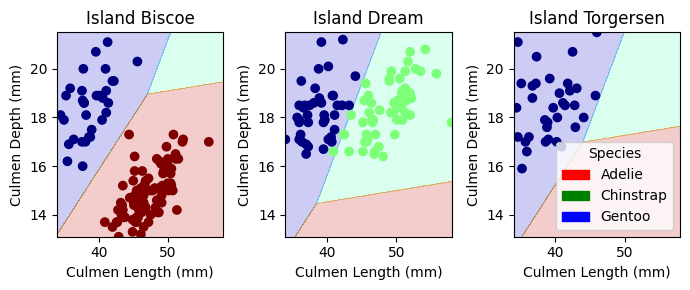

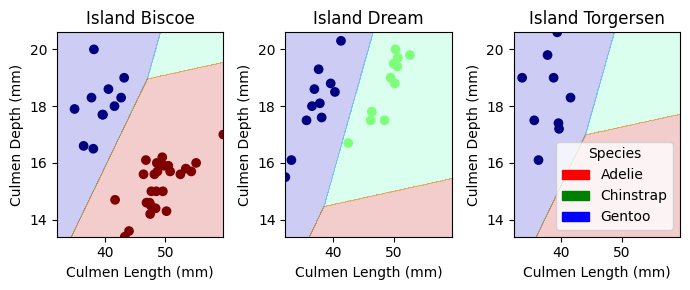

In [367]:
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i].replace("_", " "))
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(LR, X_train[LR_cols], y_train)
plot_regions(LR, X_test[LR_cols], y_test)

This visualization shows that the model is able to separate the species very well. The decision boundaries are very clear and the model is able to predict the species in the testing data with 100% accuracy. This is a very good result and indicates that the model is quite good at predicting the species of penguins using only the chosen variables. It is also clear that, as we expected, the Island is very helpful as Gentoo penguins are the only species that exist across all 3 islands, greatly simplifying the prediction complexity.

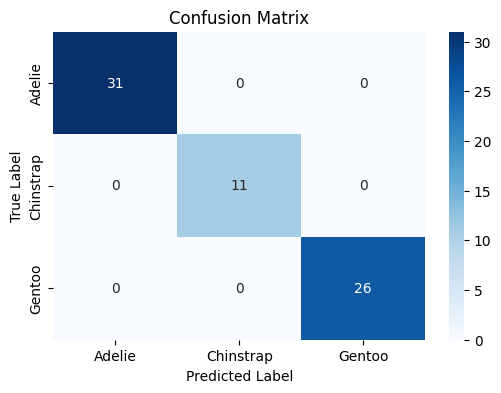

In [377]:
y_test_pred = LR.predict(X_test[LR_cols])
C = confusion_matrix(y_test, y_test_pred)

class_labels = ["Adelie", "Chinstrap", "Gentoo"]

plt.figure(figsize=(6,4))
sns.heatmap(C, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Finally, we want to take a look at the confusion matrix. Since we had 100% test accuracy, we expect the confusion matrix to be a diagonal matrix with numbers on the diagonal and 0s elsewhere. This is exactly what we see, which is a good sign that the model is working well. All of the species are predicted perfectly, which is exactly what we were looking for.